# Group 06 - Assignment 02

In [1]:
#Importing all the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)

### Import data

In [2]:
#Loading the FlightDelays dataset
flight_df = pd.read_csv('FlightDelays.csv')

# Check first 2 instances and last 2 instances
pd.concat([flight_df.head(2), flight_df.tail(2)])

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2199,1359,RU,1403,EWR,199,1/31/2004,2216,DCA,0,6,31,N16961,ontime
2200,1730,RU,1736,EWR,199,1/31/2004,2097,DCA,0,6,31,N13994,ontime


### Preprocessing

In [3]:
# Check dimension of dataset
print("There are "+ str(flight_df.shape[0]) +" rows and "+ str(flight_df.shape[1]) +" columns from the flight dataset.")

There are 2201 rows and 13 columns from the flight dataset.


In [4]:
#Filter rows where the 'ORIGIN' column is equal to 'DCA'
flight_df = flight_df[flight_df['ORIGIN'] == 'DCA']
flight_df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
11,1455,DL,1458,JFK,213,01/01/2004,746,DCA,0,4,1,N918DE,ontime
12,930,DL,932,LGA,214,01/01/2004,1746,DCA,0,4,1,N242DL,ontime
13,1230,DL,1228,LGA,214,01/01/2004,1752,DCA,0,4,1,N241DL,ontime
14,1430,DL,1429,LGA,214,01/01/2004,1756,DCA,0,4,1,N242DL,ontime


In [5]:
# Check column type
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1370 entries, 1 to 2200
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CRS_DEP_TIME   1370 non-null   int64 
 1   CARRIER        1370 non-null   object
 2   DEP_TIME       1370 non-null   int64 
 3   DEST           1370 non-null   object
 4   DISTANCE       1370 non-null   int64 
 5   FL_DATE        1370 non-null   object
 6   FL_NUM         1370 non-null   int64 
 7   ORIGIN         1370 non-null   object
 8   Weather        1370 non-null   int64 
 9   DAY_WEEK       1370 non-null   int64 
 10  DAY_OF_MONTH   1370 non-null   int64 
 11  TAIL_NUM       1370 non-null   object
 12  Flight Status  1370 non-null   object
dtypes: int64(7), object(6)
memory usage: 149.8+ KB


### Checking for missing data

In [6]:
# Checking for missing values
missing_values = flight_df.isnull().sum()
missing_percentage = (missing_values / len(flight_df)) * 100

# Creating DataFrame to show columns and their respective missing value percentages
missing_data_df = pd.DataFrame({'Column': missing_percentage.index, 'Missing Percentage': missing_percentage.values})
display(missing_data_df)

,Column,Missing Percentage
0,CRS_DEP_TIME,0.0
1,CARRIER,0.0
2,DEP_TIME,0.0
3,DEST,0.0
4,DISTANCE,0.0
5,FL_DATE,0.0
6,FL_NUM,0.0
7,ORIGIN,0.0
8,Weather,0.0
9,DAY_WEEK,0.0


We can see that the data is clean and there are no missing values

#### Rename of CARRIER

CARRIER refers to the airline identifier recorded with its abbreviation form. To make the content more intuitive, the column of abbreviation names are transformed with airlines extended names. The main reference source for the extended name is obtained from 
<a href="https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States">Wikipedia</a>
and <a href="https://azcargo.cz/en/services/support/iata-airline-codes/">IATA Airlines Codes</a>


In [7]:
# Check the instances for CARRIER
flight_df.CARRIER.unique()

array(['DH', 'DL', 'MQ', 'US', 'CO', 'RU'], dtype=object)

In [8]:
flight_df['CARRIER'].replace({
    'OH':'PSA Airlines',
    'DH':'Independence Air',
    'DL':'Delta Air Lines',
    'MQ':'Envoy Air',
    'UA':'United Airlines',
    'US':'USAirways',
    'RU':'AirBridge Cargo',
    'CO':'Continental Airlines'
}, inplace=True)

In [9]:
flight_df.CARRIER.nunique()

6

In [10]:
flight_df.CARRIER.value_counts()

USAirways               404
Delta Air Lines         388
Envoy Air               295
AirBridge Cargo         162
Continental Airlines     94
Independence Air         27
Name: CARRIER, dtype: int64

#### Transformation of Target attribute: Flight status (Converting it to binary labels : 0 for on-time and 1 for delayed)

In [11]:
# Define a mapping dictionary
status_mapping = {'ontime': 0, 'delayed': 1}

# Convert 'Flight Status' to binary labels using map function
flight_df['FLIGHT_STATUS'] = flight_df['Flight Status'].map(status_mapping)

### Statistics

In [12]:
summary_stats = flight_df.describe()
summary_stats

,CRS_DEP_TIME,DEP_TIME,DISTANCE,FL_NUM,Weather,DAY_WEEK,DAY_OF_MONTH,FLIGHT_STATUS
count,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000
mean,1364.115328,1353.612409,211.088321,2630.054745,0.012409,3.845255,16.107299,0.161314
std,429.500491,436.537598,5.805108,1397.096029,0.110742,1.889805,8.544441,0.367955
min,600.000000,548.000000,199.000000,746.000000,0.000000,1.000000,1.000000,0.000000
25%,1000.000000,956.000000,213.000000,1756.000000,0.000000,2.000000,9.000000,0.000000
50%,1400.000000,1428.000000,214.000000,2172.000000,0.000000,4.000000,16.000000,0.000000
75%,1700.000000,1707.500000,214.000000,2879.000000,0.000000,5.000000,23.000000,0.000000
max,2130.000000,2244.000000,214.000000,6155.000000,1.000000,7.000000,31.000000,1.000000


### Exploratory Data Analysis

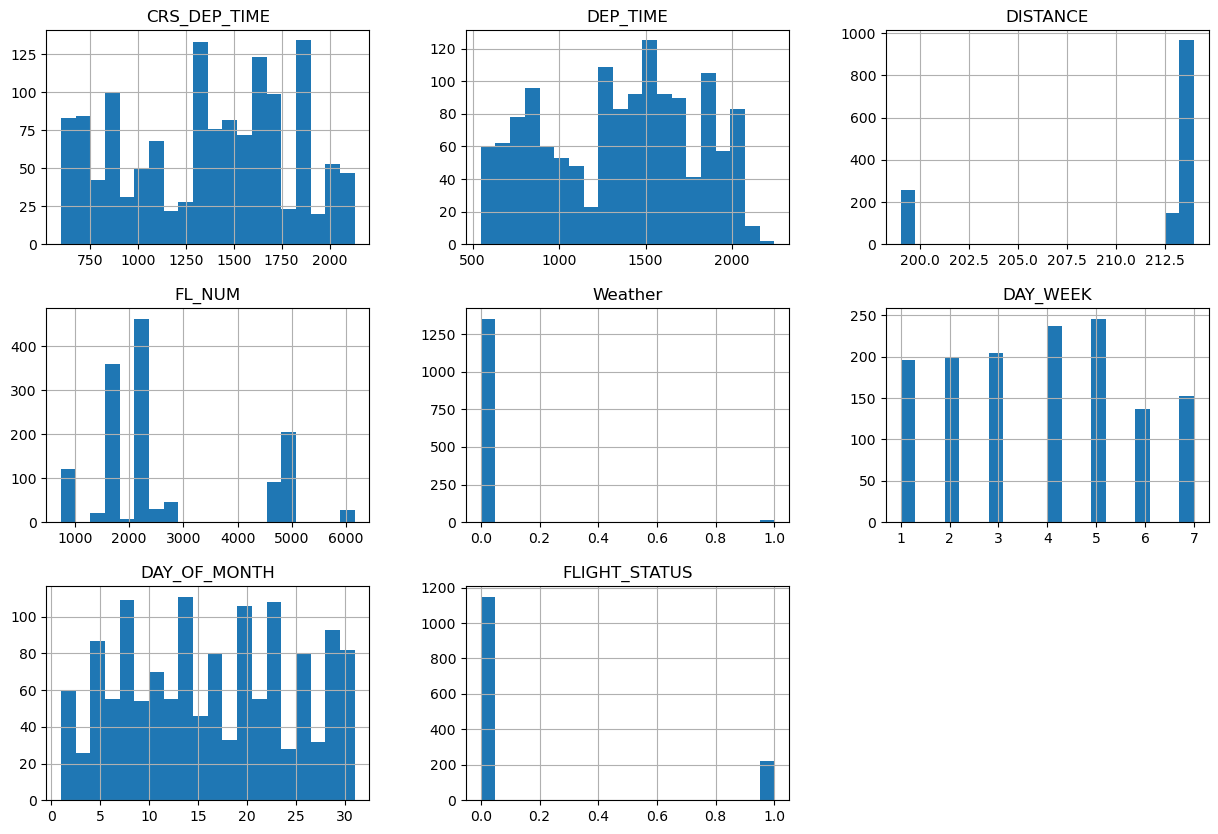

In [13]:
# Display histograms for all variables
flight_df.hist(bins=20, figsize=(15, 10))
plt.show()

In [14]:
flight_category = flight_df.select_dtypes(include=['object','category'])
flight_numerical = flight_df.select_dtypes(exclude=['object'])

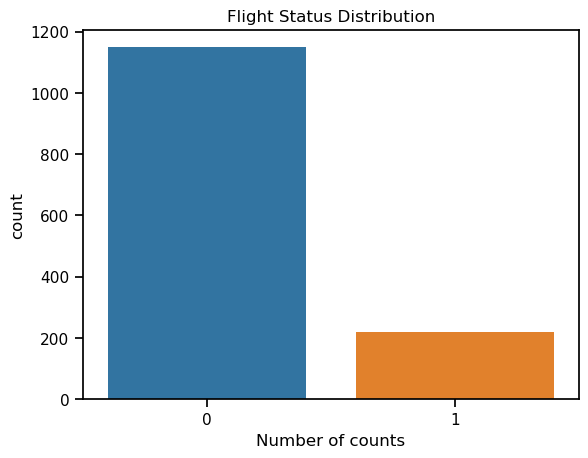

In [15]:
# Output Barplot showing the occurence of flight outcome

sns.set_context("notebook")
g=sns.countplot(x="FLIGHT_STATUS",data=flight_df)
g.set(xlabel="Number of counts")
g.set_title("Flight Status Distribution")

plt.show()

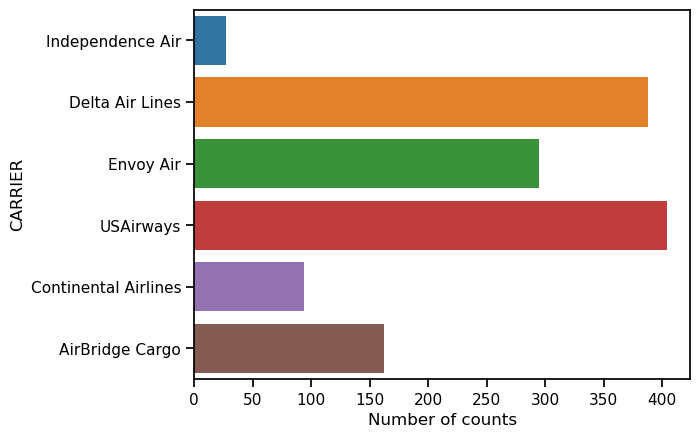

In [16]:
# Output Barplot showing the occurence of each categorical features         

sns.set_context("notebook")
g=sns.countplot(y="CARRIER",data=flight_df)
g.set(xlabel="Number of counts")

plt.show()

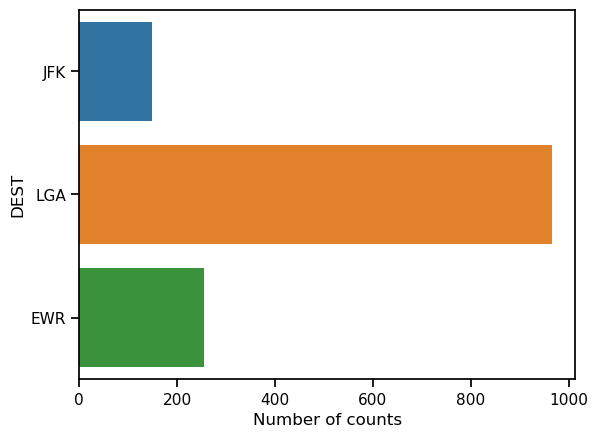

In [17]:
sns.set_context("notebook")
g=sns.countplot(y="DEST",data=flight_df)
g.set(xlabel="Number of counts")

plt.show()

In [18]:
flight_df.columns

Index(['CRS_DEP_TIME', 'CARRIER', 'DEP_TIME', 'DEST', 'DISTANCE', 'FL_DATE',
       'FL_NUM', 'ORIGIN', 'Weather', 'DAY_WEEK', 'DAY_OF_MONTH', 'TAIL_NUM',
       'Flight Status', 'FLIGHT_STATUS'],
      dtype='object')

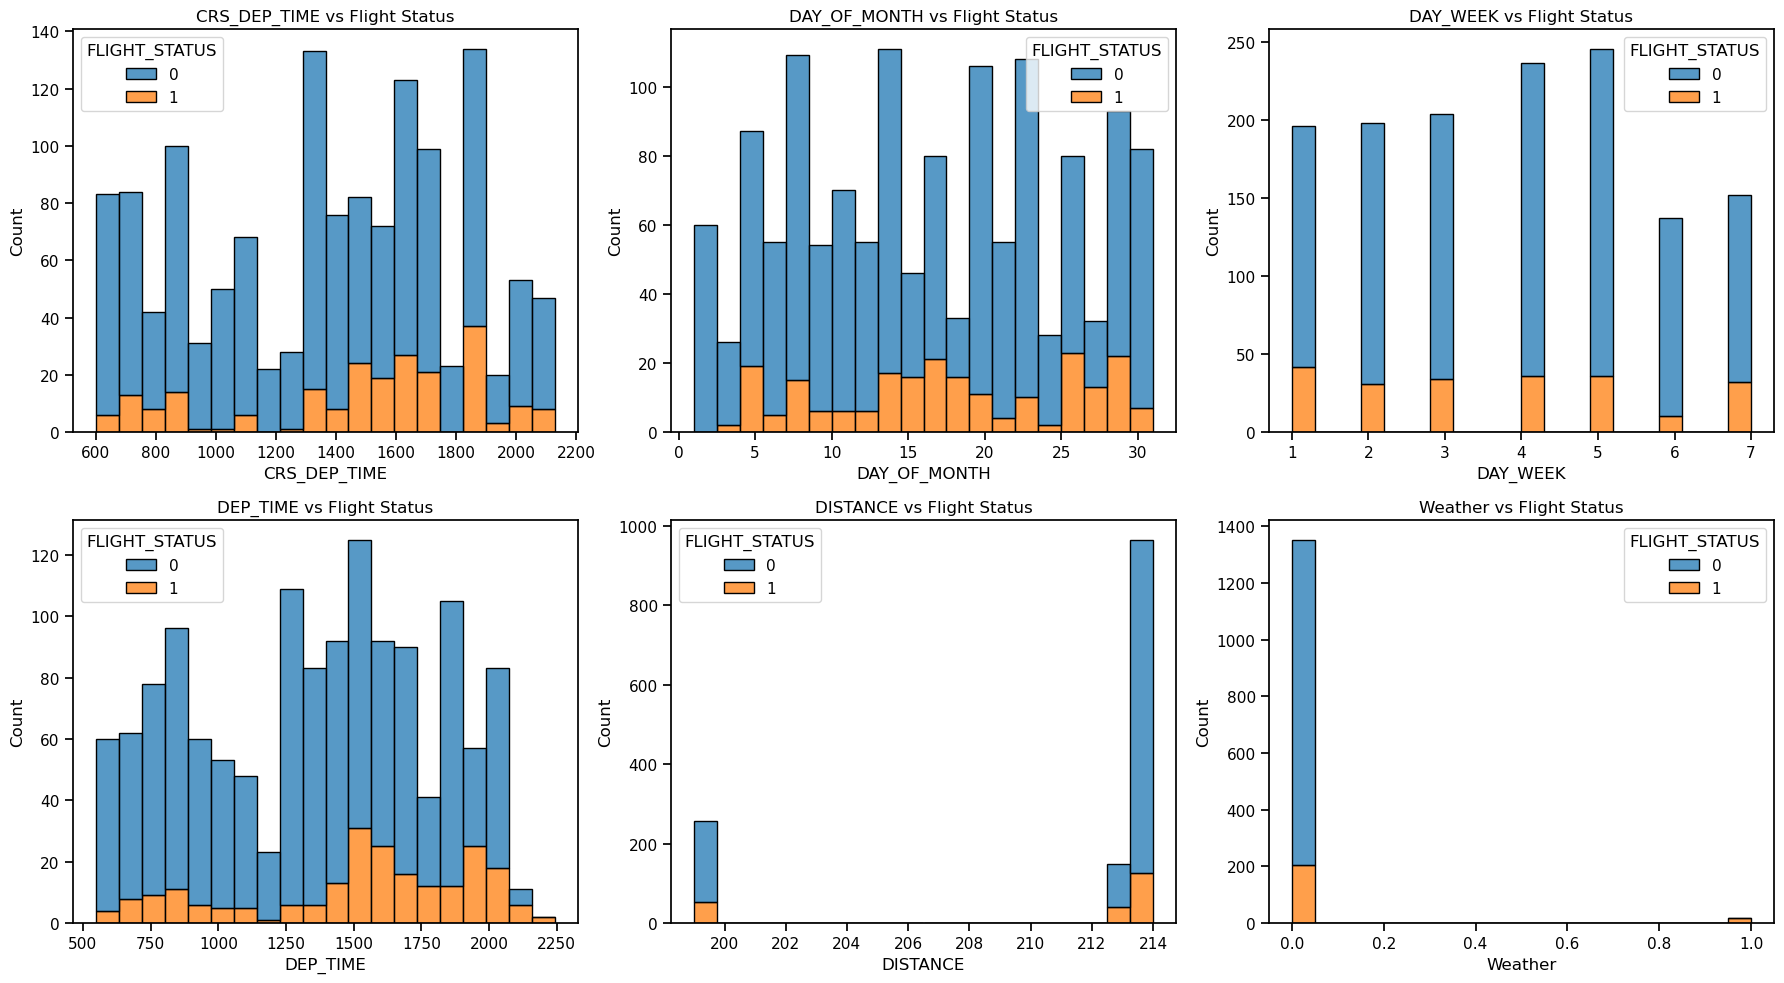

In [19]:
# Set seaborn context
sns.set_context("notebook")

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Specify variables for each subplot
variables = ['CRS_DEP_TIME', 'DAY_OF_MONTH', 'DAY_WEEK', 'DEP_TIME', 'DISTANCE', 'Weather']

# Loop through each variable and create a countplot
for i, variable in enumerate(variables):
    row = i // 3
    col = i % 3
    sns.histplot(x=variable, hue='FLIGHT_STATUS', data=flight_df, multiple='stack',bins=20, ax=axes[row, col])
    axes[row, col].set_title(f'{variable} vs Flight Status')
    
# Adjust layout
plt.tight_layout()
plt.show()


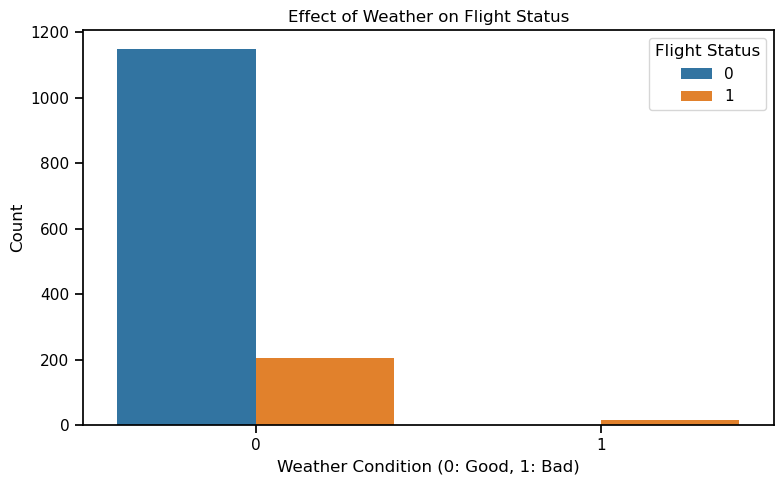

In [20]:
# Set seaborn context
sns.set_context("notebook")

# Create the countplot
plt.figure(figsize=(8, 5))
sns.countplot(x='Weather', hue='FLIGHT_STATUS', data=flight_df)

# Set labels and title
plt.xlabel('Weather Condition (0: Good, 1: Bad)')
plt.ylabel('Count')
plt.legend(title='Flight Status', loc='upper right', labels=['On-time', 'Delayed'])
plt.title('Effect of Weather on Flight Status')

# Show plot
plt.legend(title='Flight Status', loc='upper right')
plt.tight_layout()
plt.show()

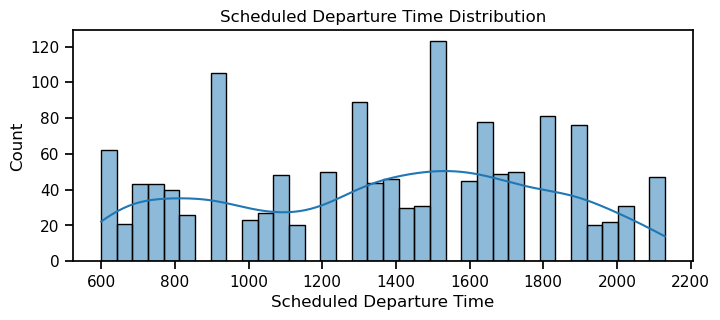

In [21]:
#Scheduled Departure time Distribution
plt.figure(figsize=(8, 3))
sns.histplot(flight_df['CRS_DEP_TIME'], bins=36, kde=True)
plt.title('Scheduled Departure Time Distribution')
plt.xlabel('Scheduled Departure Time')
plt.show()

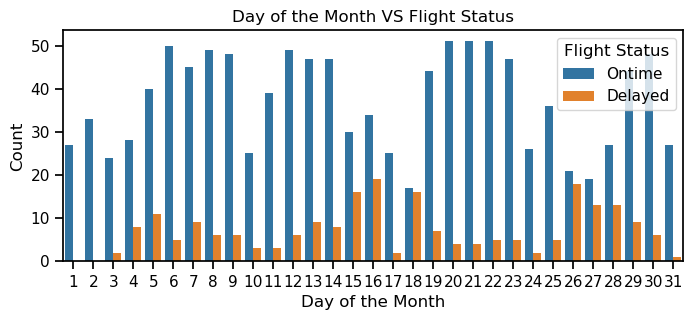

In [22]:
# Plotting the effect of day of the month on flight status
plt.figure(figsize=(8, 3))
sns.countplot(x='DAY_OF_MONTH', hue='Flight Status', data=flight_df)
plt.title('Day of the Month VS Flight Status')
plt.xlabel('Day of the Month')
plt.ylabel('Count')
plt.legend(title='Flight Status', loc='upper right', labels=['Ontime', 'Delayed'])
plt.show()

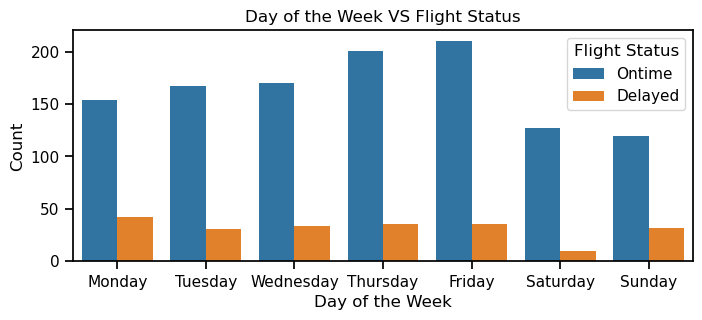

In [23]:
#Create a copy of the subset you want to work with
copy_df = flight_df.copy()

# Mapping dictionary for day of the week
day_week_mapping = {
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday',
    7: 'Sunday'
}

# Replace numerical values with day names in the subset DataFrame
copy_df['DAY_WEEK'] = copy_df['DAY_WEEK'].map(day_week_mapping)

# Plotting the effect of day of the week on flight status for the subset
plt.figure(figsize=(8, 3))
sns.countplot(x='DAY_WEEK', hue='Flight Status', data=copy_df, order=day_week_mapping.values())
plt.title('Day of the Week VS Flight Status')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.legend(title='Flight Status', loc='upper right', labels=['Ontime', 'Delayed'])
plt.show()


### Variabilities

In [24]:
#Variabilities
print("Variability in Distance:")
print("Standard Deviation:", flight_df['DISTANCE'].std())
print("Interquartile Range (IQR):", flight_df['DISTANCE'].quantile(0.75) - flight_df['DISTANCE'].quantile(0.25))

Variability in Distance:
Standard Deviation: 5.805108021139422
Interquartile Range (IQR): 1.0


###  Model Building

#### One hot encoding for categorical attributes

In [25]:
flight_df.columns

Index(['CRS_DEP_TIME', 'CARRIER', 'DEP_TIME', 'DEST', 'DISTANCE', 'FL_DATE',
       'FL_NUM', 'ORIGIN', 'Weather', 'DAY_WEEK', 'DAY_OF_MONTH', 'TAIL_NUM',
       'Flight Status', 'FLIGHT_STATUS'],
      dtype='object')

In [26]:
flight_df_new = pd.get_dummies(flight_df, columns=['CARRIER','DEST','ORIGIN'], drop_first=True)

In [27]:
flight_df_new.columns

Index(['CRS_DEP_TIME', 'DEP_TIME', 'DISTANCE', 'FL_DATE', 'FL_NUM', 'Weather',
       'DAY_WEEK', 'DAY_OF_MONTH', 'TAIL_NUM', 'Flight Status',
       'FLIGHT_STATUS', 'CARRIER_Continental Airlines',
       'CARRIER_Delta Air Lines', 'CARRIER_Envoy Air',
       'CARRIER_Independence Air', 'CARRIER_USAirways', 'DEST_JFK',
       'DEST_LGA'],
      dtype='object')

In [28]:
# Dropping columns 
flight_df_new.drop(['FL_DATE','TAIL_NUM','Flight Status'],
                 axis = 1, inplace = True)

Let's start by splitting our data into a training set and a test set.

In [29]:
#Splitting the data into features (X) and target variable (y)
X = flight_df_new.drop('FLIGHT_STATUS', axis=1)
y = flight_df_new['FLIGHT_STATUS']

In [30]:
#Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
X_train.columns

Index(['CRS_DEP_TIME', 'DEP_TIME', 'DISTANCE', 'FL_NUM', 'Weather', 'DAY_WEEK',
       'DAY_OF_MONTH', 'CARRIER_Continental Airlines',
       'CARRIER_Delta Air Lines', 'CARRIER_Envoy Air',
       'CARRIER_Independence Air', 'CARRIER_USAirways', 'DEST_JFK',
       'DEST_LGA'],
      dtype='object')

In [32]:
#Standardizing features

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
flight_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1370 entries, 1 to 2200
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   CRS_DEP_TIME                  1370 non-null   int64
 1   DEP_TIME                      1370 non-null   int64
 2   DISTANCE                      1370 non-null   int64
 3   FL_NUM                        1370 non-null   int64
 4   Weather                       1370 non-null   int64
 5   DAY_WEEK                      1370 non-null   int64
 6   DAY_OF_MONTH                  1370 non-null   int64
 7   FLIGHT_STATUS                 1370 non-null   int64
 8   CARRIER_Continental Airlines  1370 non-null   uint8
 9   CARRIER_Delta Air Lines       1370 non-null   uint8
 10  CARRIER_Envoy Air             1370 non-null   uint8
 11  CARRIER_Independence Air      1370 non-null   uint8
 12  CARRIER_USAirways             1370 non-null   uint8
 13  DEST_JFK                      137

In [34]:
flight_df_new["FLIGHT_STATUS"] = flight_df_new["FLIGHT_STATUS"].astype('category')

In [35]:
flight_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1370 entries, 1 to 2200
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   CRS_DEP_TIME                  1370 non-null   int64   
 1   DEP_TIME                      1370 non-null   int64   
 2   DISTANCE                      1370 non-null   int64   
 3   FL_NUM                        1370 non-null   int64   
 4   Weather                       1370 non-null   int64   
 5   DAY_WEEK                      1370 non-null   int64   
 6   DAY_OF_MONTH                  1370 non-null   int64   
 7   FLIGHT_STATUS                 1370 non-null   category
 8   CARRIER_Continental Airlines  1370 non-null   uint8   
 9   CARRIER_Delta Air Lines       1370 non-null   uint8   
 10  CARRIER_Envoy Air             1370 non-null   uint8   
 11  CARRIER_Independence Air      1370 non-null   uint8   
 12  CARRIER_USAirways             1370 non-null   ui

### K-Nearest Neighbors (KNN)

In [36]:
#K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
knn_predictions = knn_model.predict(X_test_scaled)

accuracy_knn=accuracy_score(y_test, knn_predictions)
print(f'KNN Accuracy:',accuracy_knn)
print(classification_report(y_test, knn_predictions))

KNN Accuracy: 0.8540145985401459
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       226
           1       0.75      0.25      0.38        48

    accuracy                           0.85       274
   macro avg       0.81      0.62      0.65       274
weighted avg       0.84      0.85      0.82       274



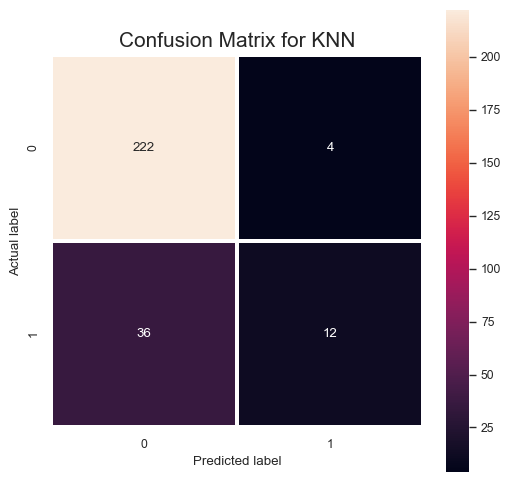

In [37]:
#Confusion Matrix for KNN
conf_matrix = confusion_matrix(y_test, knn_predictions)
sns.set(context="paper")
plt.subplots(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", linewidths=1.5, square = True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix for KNN", size = 15)
plt.show()

### Multinomial Naive Bayes

In [38]:
nb = MultinomialNB()
    
nb.fit(X_train_scaled, y_train)
nb_predictions = nb.predict(X_test_scaled)
accuracy_naive = accuracy_score(y_test, nb_predictions)

print("NB Accuracy",accuracy_naive)
print(classification_report(y_test, nb_predictions))


NB Accuracy 0.8357664233576643
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       226
           1       1.00      0.06      0.12        48

    accuracy                           0.84       274
   macro avg       0.92      0.53      0.51       274
weighted avg       0.86      0.84      0.77       274



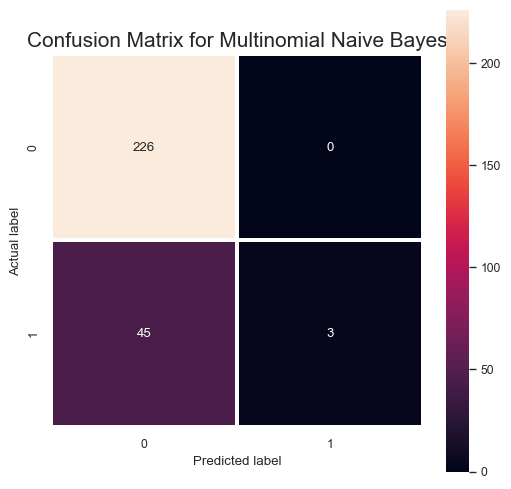

In [39]:
#Confusion Matrix for Multinomial Naive Bayes
conf_matrix = confusion_matrix(y_test, nb_predictions)
sns.set(context="paper")
plt.subplots(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", linewidths=1.5, square = True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix for Multinomial Naive Bayes", size = 15)
plt.show()

### Decision Tree

In [40]:
# Initialize Decision Tree classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_scaled, y_train)
dt_predictions = dt_classifier.predict(X_test_scaled)

accuracy_dec = accuracy_score(y_test, dt_predictions)
print("Decision Tree Accuracy:", accuracy_dec)
print(classification_report(y_test, dt_predictions))

Decision Tree Accuracy: 0.8029197080291971
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       226
           1       0.42      0.35      0.39        48

    accuracy                           0.80       274
   macro avg       0.65      0.63      0.63       274
weighted avg       0.79      0.80      0.80       274



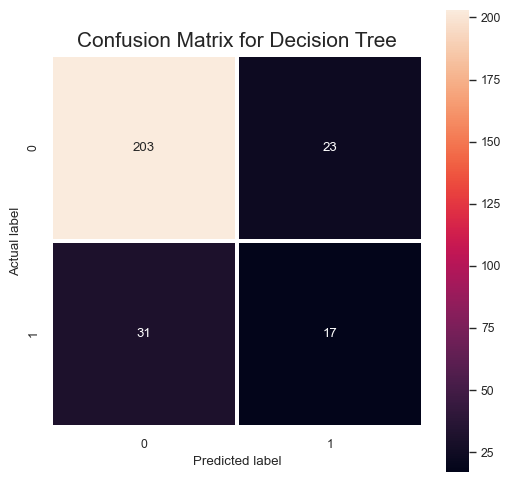

In [41]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, dt_predictions)
sns.set(context="paper")
plt.subplots(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", linewidths=1.5, square = True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix for Decision Tree", size = 15)
plt.show()

### Random Forest Classifier

In [42]:
#Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)

accuracy_rf = accuracy_score(y_test, rf_predictions)
print(f'Random Forest Accuracy: {accuracy_score(y_test, rf_predictions)}')
print(classification_report(y_test, rf_predictions))

Random Forest Accuracy: 0.864963503649635
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       226
           1       0.87      0.27      0.41        48

    accuracy                           0.86       274
   macro avg       0.87      0.63      0.67       274
weighted avg       0.87      0.86      0.83       274



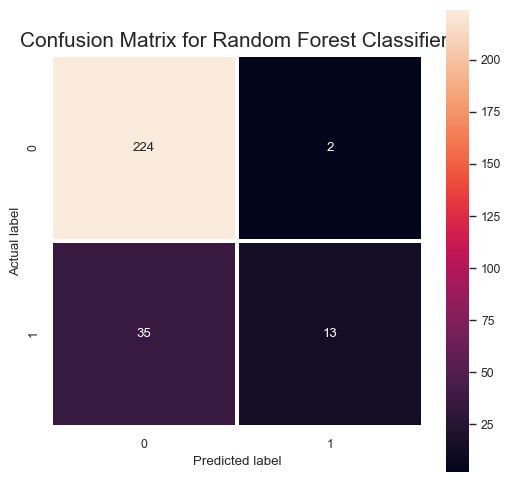

In [43]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, rf_predictions)
sns.set(context="paper")
plt.subplots(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", linewidths=1.5, square = True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix for Random Forest Classifier ", size = 15)
plt.show()

In [44]:
print("K-Nearest Neighbours Accuracy:",accuracy_knn)
print("Multinomial Naive Bayes Accuracy:",accuracy_naive)
print("Decision Tree Accuracy:",accuracy_dec)
print("Random Forest Accuracy:",accuracy_rf)

K-Nearest Neighbours Accuracy: 0.8540145985401459
Multinomial Naive Bayes Accuracy: 0.8357664233576643
Decision Tree Accuracy: 0.8029197080291971
Random Forest Accuracy: 0.864963503649635
